# Ice Optics Parameterization Comparison (v1a)

# Test 1 - Altitude (Cloud Temperature)

For ranges used in Test 1 - Altitude/Temperature:

* Ice Mass Mixing ratio qi (kg/kg) range: (0.04 to 0.11) * 0.001

* Ice Water Content IWC (g/m3) (We use an average density of 0.3 kg m-3 between 10 km and 15 km):
iwc = q_i * 1000 * 0.3

* Ice Water Path IWP (g/m2):
iwp = np.arange(0.1, 300.1, 0.1)

* Fized Effective Radius r_e (um) (not needed for this case)

* Temperature T (K) range: 190 to 260.5 

In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import pandas as pd
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

# Interscheme Comparison

### Reading Tropical Climatology

In [2]:
in_dir    = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
file      = 'input_1D_matrix_height_v6.nc'
height_in = xr.open_dataset(in_dir+file)

In [3]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_28596/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [4]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(height_in.pressure_hl.values)

height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(height_in.pressure_hl.values)

In [5]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

height_hl_pd    = pd.Series(height_hl[0])

### Reading Optical Schemes LUT

In [6]:
in_dir    = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')

fu_sw = xr.open_dataset(in_dir+'FuSW_test1_LUT_v1a.nc')
fu_lw = xr.open_dataset(in_dir+'FuLW_test1_LUT_v1a.nc')
baran14_sw = xr.open_dataset(in_dir+'Baran14SW_test1_LUT_v1a.nc')
baran14_lw = xr.open_dataset(in_dir+'Baran14LW_test1_LUT_v1a.nc')
yi_sw = xr.open_dataset(in_dir+'YiSW_test1_LUT_v1a.nc')
yi_lw = xr.open_dataset(in_dir+'YiLW_test1_LUT_v1a.nc')
baran16_sw = xr.open_dataset(in_dir+'Baran16SW_test1_LUT_v1a.nc')
baran16_lw = xr.open_dataset(in_dir+'Baran16LW_test1_LUT_v1a.nc')

## Mass Extinction Coefficient $K_{ext}$ $(m^2/g)$:

Position of 30 um (Fixed Size):

In [7]:
# Ice Mass Mixing ratio (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001
# Ice Water Content (g m-3), with average density of 0.3 kg m-3 between 10 km and 15 km:
iwc = q_i * 1000 * 0.3
# Effective Radius (um)
r_e = np.arange(5, 60, 1) # See limits of LUT from Yi in radiation_ice_optics_yi.F90 (< 60 um)
# Temperature
T = np.arange(190, 260.5, .5) # Temperature (K)

pos30 = np.where(r_e == 30)[0][0]

Test with only one band:
- SW: 1.299 um - 1.626 um (old: 0.625 um (wn1) - 0.441 um (wn2))
- LW: 10.2 um (wn1) - 9.259 um (wn2)

In [8]:
fu_sw_K_ext = fu_sw.K_ext.values
fu_lw_K_ext = fu_lw.K_ext.values
baran14_sw_K_ext = baran14_sw.K_ext.values
baran14_lw_K_ext = baran14_lw.K_ext.values
yi_sw_K_ext = yi_sw.K_ext.values
yi_lw_K_ext = yi_lw.K_ext.values
baran16_sw_K_ext = baran16_sw.K_ext.values
baran16_lw_K_ext = baran16_lw.K_ext.values

Fu SW has some negative values for K_abs. Maybe because of high ssa. Check the parameterization.

In [9]:
tempi = height_in.sizes['column']     # Temperature Levels
profi = height_in.sizes['half_level'] # Vertical Profile

## K_ext Calculation Matrices:
K_ext_sw_t1 = np.zeros((4, tempi, profi))
K_ext_lw_t1 = np.zeros((4, tempi, profi))

## Matrices for plotting:
K_ext_sw_t1_plot = np.zeros((4, profi, tempi))
K_ext_lw_t1_plot = np.zeros((4, profi, tempi))

for opt in range(4): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = height_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = height_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: 
                K_ext_sw_t1[opt, i, q_ix] = 0
                K_ext_lw_t1[opt, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_i        = q_difference.argmin()
                K_ext_sw_t1[0, i, q_ix] = fu_sw_K_ext[5, pos30, min_i] # Only One Band Selected 1.45 um
                K_ext_lw_t1[0, i, q_ix] = fu_lw_K_ext[6, pos30, min_i] # Only One Band Selected 9.7 um
                K_ext_sw_t1[1, i, q_ix] = baran14_sw_K_ext[5, min_i] # Only One Band Selected 1.45 um 
                K_ext_lw_t1[1, i, q_ix] = baran14_lw_K_ext[6, min_i] # Only One Band Selected 9.7 um
                K_ext_sw_t1[2, i, q_ix] = yi_sw_K_ext[5, pos30, min_i] # Only One Band Selected 1.45 um
                K_ext_lw_t1[2, i, q_ix] = yi_lw_K_ext[6, pos30, min_i] # Only One Band Selected 9.7 um
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                K_ext_sw_t1[3, i, q_ix] = baran16_sw_K_ext[5, min_Tdiff, min_i] # Only One Band Selected 1.45 um 
                K_ext_lw_t1[3, i, q_ix] = baran16_lw_K_ext[6, min_Tdiff, min_i] # Only One Band Selected 9.7 um
                
    # For plotting:
    K_ext_sw_t1_plot[opt,:,:] = np.transpose(K_ext_sw_t1[opt,:,:])
    K_ext_lw_t1_plot[opt,:,:] = np.transpose(K_ext_lw_t1[opt,:,:])

Interscheme Difference:

In [10]:
# Shortwave:
K_ext_sw_t1_diff_plot    = np.zeros((3, profi, tempi))
K_ext_sw_t1_diff_plot[0] = K_ext_sw_t1_plot[1] - K_ext_sw_t1_plot[0] # Baran2014 - Fu
K_ext_sw_t1_diff_plot[1] = K_ext_sw_t1_plot[2] - K_ext_sw_t1_plot[0] # Yi - Fu
K_ext_sw_t1_diff_plot[2] = K_ext_sw_t1_plot[3] - K_ext_sw_t1_plot[0] # Baran2016 - Fu

# Longwave:
K_ext_lw_t1_diff_plot    = np.zeros((3, profi, tempi))
K_ext_lw_t1_diff_plot[0] = K_ext_lw_t1_plot[1] - K_ext_lw_t1_plot[0] # Baran2014 - Fu
K_ext_lw_t1_diff_plot[1] = K_ext_lw_t1_plot[2] - K_ext_lw_t1_plot[0] # Yi - Fu
K_ext_lw_t1_diff_plot[2] = K_ext_lw_t1_plot[3] - K_ext_lw_t1_plot[0] # Baran2016 - Fu

In [11]:
# Shortwave K_ext differences:
print('Shortwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(K_ext_sw_t1_diff_plot[0][np.nonzero(K_ext_sw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',K_ext_sw_t1_diff_plot[0].min())
print('Yi - Fu max: ',K_ext_sw_t1_diff_plot[1].max())
print('Yi - Fu min: ',K_ext_sw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',K_ext_sw_t1_diff_plot[2].max())
print('Baran2016 - Fu min: ',K_ext_sw_t1_diff_plot[2].min())

print('')
# Longwave K_ext differences:
print('Longwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(K_ext_lw_t1_diff_plot[0][np.nonzero(K_ext_lw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',K_ext_lw_t1_diff_plot[0].min())
print('Yi - Fu max: ',K_ext_lw_t1_diff_plot[1].max())
print('Yi - Fu min: ',K_ext_lw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(K_ext_lw_t1_diff_plot[2][np.nonzero(K_ext_lw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.min(K_ext_lw_t1_diff_plot[2][np.nonzero(K_ext_lw_t1_diff_plot[2])]))

Shortwave CRH Differences:
Baran2014 - Fu max:  -0.00440806625114553
Baran2014 - Fu min:  -0.004428247477828953
Yi - Fu max:  0.0
Yi - Fu min:  -0.004066960245750845
Baran2016 - Fu max:  0.05570401290935567
Baran2016 - Fu min:  -0.004818007350297526

Longwave CRH Differences:
Baran2014 - Fu max:  -0.008315067326093044
Baran2014 - Fu min:  -0.008339569816768672
Yi - Fu max:  0.0
Yi - Fu min:  -0.008007089388332785
Baran2016 - Fu max:  0.043971673248920894
Baran2016 - Fu min:  -0.012515544057514608


In [12]:
K_ext_sw_t1_diff_plot[K_ext_sw_t1_diff_plot == 0] = np.nan
K_ext_lw_t1_diff_plot[K_ext_lw_t1_diff_plot == 0] = np.nan

In [13]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


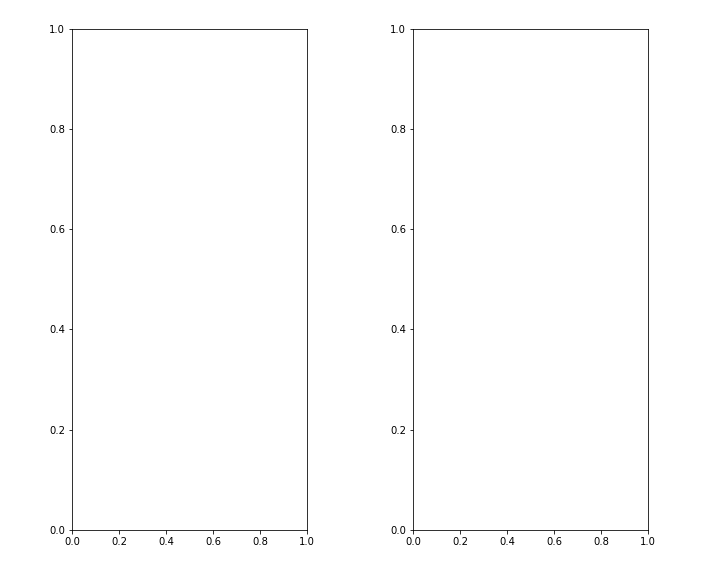

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [33]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 8 # inches
flength  = 10 # inches

rows    = 1
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
#     if diff == 0:
#         # For SW:
#         vmini_sw   = -0.004062
#         vmaxi_sw   = 0.00001#-0.004048
#         #tickbar_sw = [vmini_sw, -0.75e-5 , 0]
#         cmap_sw    = 'Blues_r'#Blues'#'Reds'
#         norm = colors.PowerNorm(gamma = 0.01)
#         #labelpad    = -30
#         #For LW:
#         vmini_lw   = -0.0084
#         vmaxi_lw   = 0.0001
#         #tickbar_lw = [vmini_lw, -0.0175 , 0]
#         cmap_lw    = 'Blues_r'#'RdBu_r'##'Blues'cv
#         schi = diff
    if diff == 0:
        # For SW:
        vmini_sw   = -0.00464
        vmaxi_sw   = 0.056
        #tickbar_sw = [vmini_sw, -4.2e-7, 0]
        #labelpad = -30
        cmap_sw    = 'RdBu_r'#'Blues'#'Reds'
        norm       = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        #For LW:
        vmini_lw   = -0.0126
        vmaxi_lw   = 0.044
        #tickbar_lw = [vmini_lw, -3.5e-3 , 0]
        cmap_lw    = 'RdBu_r'#'Blues'#'Reds'
        schi = diff + 2
    
    # Shortwave K_ext Difference
    im = ax[diff, 0].imshow(K_ext_sw_t1_diff_plot[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta K_{ext}$ ($m^{2}/g$)', labelpad = -40, y = 1.22, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title(r'$K_{ext}$ Diff. $(1.45 \mu m)$', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave K_ext Difference
    im = ax[diff, 1].imshow(K_ext_lw_t1_diff_plot[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta K_{ext}$ ($m^{2}/g$)', labelpad = -40, y = 1.22, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title(r'$K_{ext}$ Diff. $(9.73 \mu m)$', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, K_ext_sw_t1.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_diff_1S_v6c.png', dpi=500)

<IPython.core.display.Javascript object>


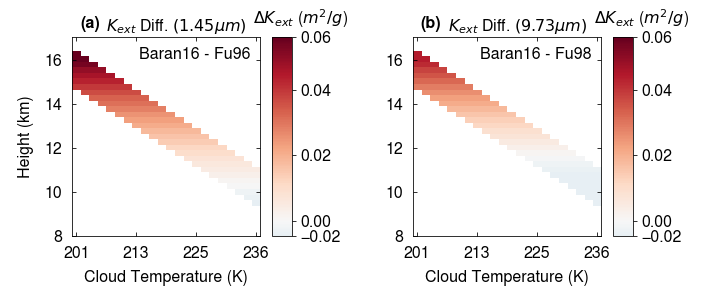

In [14]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 4 # inches
flength  = 10 # inches

rows    = 1
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.87, bottom = 0.18, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
#     if diff == 0:
#         # For SW:
#         vmini_sw   = -0.004062
#         vmaxi_sw   = 0.00001#-0.004048
#         #tickbar_sw = [vmini_sw, -0.75e-5 , 0]
#         cmap_sw    = 'Blues_r'#Blues'#'Reds'
#         norm = colors.PowerNorm(gamma = 0.01)
#         #labelpad    = -30
#         #For LW:
#         vmini_lw   = -0.0084
#         vmaxi_lw   = 0.0001
#         #tickbar_lw = [vmini_lw, -0.0175 , 0]
#         cmap_lw    = 'Blues_r'#'RdBu_r'##'Blues'cv
#         schi = diff
    if diff == 0:
        # For SW:
        vmini_sw   = -0.00464
        vmaxi_sw   = 0.056
        #tickbar_sw = [vmini_sw, -4.2e-7, 0]
        #labelpad = -30
        cmap_sw    = 'RdBu_r'#'Blues'#'Reds'
        norm       = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        #For LW:
        vmini_lw   = -0.0126
        vmaxi_lw   = 0.044
        #tickbar_lw = [vmini_lw, -3.5e-3 , 0]
        cmap_lw    = 'RdBu_r'#'Blues'#'Reds'
        schi = diff + 2
    
    # Shortwave K_ext Difference
    im = ax[0].imshow(K_ext_sw_t1_diff_plot[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta K_{ext}$ ($m^{2}/g$)', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[0].set_title(r'$K_{ext}$ Diff. $(1.45 \mu m)$', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave K_ext Difference
    im = ax[1].imshow(K_ext_lw_t1_diff_plot[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta K_{ext}$ ($m^{2}/g$)', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[1].set_title(r'$K_{ext}$ Diff. $(9.73 \mu m)$', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, K_ext_sw_t1.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran16 - Fu96']
Diff_lw         = ['Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 0:
            ax[j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[j].set_xticks(xticks)
        ax[j].set_xticklabels(xticklabels) #[::-1]
        ax[j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[j].set_yticks(yticks)
        ax[j].set_yticklabels(yticklabels)
        if j == 0:
            ax[j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_diff_1S_v6c.png', dpi=500)

### Single Scatter Albedo

Position of 30 um (Fixed Size):

In [9]:
pos30 = np.where(r_e == 30)[0][0]

Test with only one band:
- SW: 0.625 um (wn1) - 0.441 um (wn2)
- LW: 10.2 um (wn1) - 9.259 um (wn2)

In [44]:
fu_sw_ssa = fu_sw.ssa.values
fu_lw_ssa = fu_lw.ssa.values
baran14_sw_ssa = baran14_sw.ssa.values
baran14_lw_ssa = baran14_lw.ssa.values
yi_sw_ssa = yi_sw.ssa.values
yi_lw_ssa = yi_lw.ssa.values
baran16_sw_ssa = baran16_sw.ssa.values
baran16_lw_ssa = baran16_lw.ssa.values

In [45]:
tempi = height_in.sizes['column']     # Temperature Levels
profi = height_in.sizes['half_level'] # Vertical Profile

## SSA Calculation Matrices:
ssa_sw_t1 = np.zeros((4, tempi, profi))
ssa_lw_t1 = np.zeros((4, tempi, profi))

## Matrices for plotting:
ssa_sw_t1_plot = np.zeros((4, profi, tempi))
ssa_lw_t1_plot = np.zeros((4, profi, tempi))

for opt in range(4): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = height_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = height_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: 
                ssa_sw_t1[opt, i, q_ix] = 0
                ssa_lw_t1[opt, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_i        = q_difference.argmin()
                ssa_sw_t1[0, i, q_ix] = fu_sw_ssa[5, pos30, min_i] # Only One Band Selected 0.5 um
                ssa_lw_t1[0, i, q_ix] = fu_lw_ssa[6, pos30, min_i] # Only One Band Selected 9.7 um
                ssa_sw_t1[1, i, q_ix] = baran14_sw_ssa[5, min_i] # Only One Band Selected 0.5 um 
                ssa_lw_t1[1, i, q_ix] = baran14_lw_ssa[6, min_i] # Only One Band Selected 9.7 um
                ssa_sw_t1[2, i, q_ix] = yi_sw_ssa[5, pos30, min_i] # Only One Band Selected 0.5 um
                ssa_lw_t1[2, i, q_ix] = yi_lw_ssa[6, pos30, min_i] # Only One Band Selected 9.7 um
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                ssa_sw_t1[3, i, q_ix] = baran16_sw_ssa[5, min_Tdiff, min_i] # Only One Band Selected 0.5 um 
                ssa_lw_t1[3, i, q_ix] = baran16_lw_ssa[6, min_Tdiff, min_i] # Only One Band Selected 9.7 um
                
    # For plotting:
    ssa_sw_t1_plot[opt,:,:] = np.transpose(ssa_sw_t1[opt,:,:])
    ssa_lw_t1_plot[opt,:,:] = np.transpose(ssa_lw_t1[opt,:,:])

Interscheme Difference:

In [64]:
# Shortwave:
ssa_sw_t1_diff_plot    = np.zeros((3, profi, tempi))
ssa_sw_t1_diff_plot[0] = ssa_sw_t1_plot[1] - ssa_sw_t1_plot[0] # Baran2014 - Fu
ssa_sw_t1_diff_plot[1] = ssa_sw_t1_plot[2] - ssa_sw_t1_plot[0] # Yi - Fu
ssa_sw_t1_diff_plot[2] = ssa_sw_t1_plot[3] - ssa_sw_t1_plot[0] # Baran2016 - Fu

# Longwave:
ssa_lw_t1_diff_plot    = np.zeros((3, profi, tempi))
ssa_lw_t1_diff_plot[0] = ssa_lw_t1_plot[1] - ssa_lw_t1_plot[0] # Baran2014 - Fu
ssa_lw_t1_diff_plot[1] = ssa_lw_t1_plot[2] - ssa_lw_t1_plot[0] # Yi - Fu
ssa_lw_t1_diff_plot[2] = ssa_lw_t1_plot[3] - ssa_lw_t1_plot[0] # Baran2016 - Fu

New version

In [65]:
# Shortwave SSA differences:
print('Shortwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(ssa_sw_t1_diff_plot[0][np.nonzero(ssa_sw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',np.min(ssa_sw_t1_diff_plot[0][np.nonzero(ssa_sw_t1_diff_plot[0])]))
print('Yi - Fu max: ',ssa_sw_t1_diff_plot[1].max())
print('Yi - Fu min: ',ssa_sw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(ssa_sw_t1_diff_plot[2][np.nonzero(ssa_sw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.max(ssa_sw_t1_diff_plot[2][np.nonzero(ssa_sw_t1_diff_plot[2])]))


print('')
# Longwave SSA differences:
print('Longwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(ssa_lw_t1_diff_plot[0][np.nonzero(ssa_lw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',np.max(ssa_lw_t1_diff_plot[0][np.nonzero(ssa_lw_t1_diff_plot[0])]))
print('Yi - Fu max: ',ssa_lw_t1_diff_plot[1].max())
print('Yi - Fu min: ',ssa_lw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(ssa_lw_t1_diff_plot[2][np.nonzero(ssa_lw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.min(ssa_lw_t1_diff_plot[2][np.nonzero(ssa_lw_t1_diff_plot[2])]))

Shortwave CRH Differences:
Baran2014 - Fu max:  0.02428761495440146
Baran2014 - Fu min:  0.008929490790416272
Yi - Fu max:  0.020211718019045977
Yi - Fu min:  0.0
Baran2016 - Fu max:  0.042568392866514704
Baran2016 - Fu min:  0.042568392866514704

Longwave CRH Differences:
Baran2014 - Fu max:  -0.011492730222727898
Baran2014 - Fu min:  -0.011492730222727898
Yi - Fu max:  0.0
Yi - Fu min:  -0.006607004646692394
Baran2016 - Fu max:  0.041296122856933626
Baran2016 - Fu min:  0.0401342788188942


In [66]:
ssa_sw_t1_diff_plot[ssa_sw_t1_diff_plot == 0] = np.nan
ssa_lw_t1_diff_plot[ssa_lw_t1_diff_plot == 0] = np.nan

In [67]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


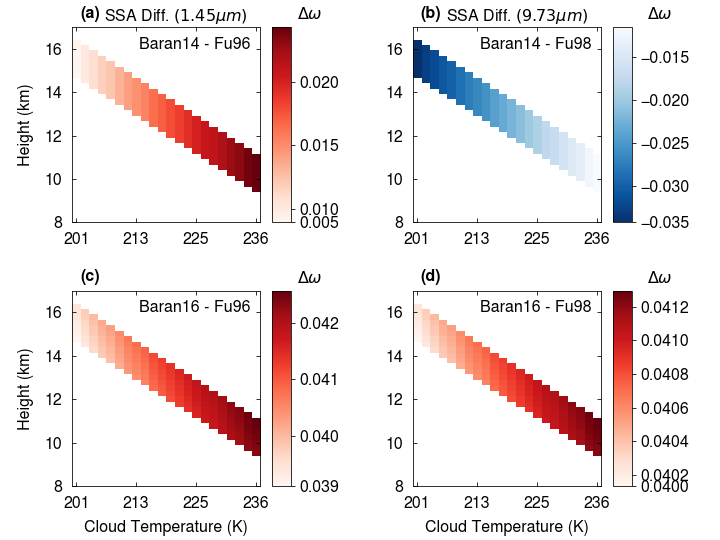

In [85]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 7.5 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if diff == 0:
        # For SW:
        vmini_sw   = -0.001
        vmaxi_sw   = 0.025#-0.004048
        #tickbar_sw = [vmini_sw, -0.75e-5 , 0]
        cmap_sw    = 'Reds'#Blues'#'Reds'
        norm_sw = colors.PowerNorm(gamma = 1)#MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        #labelpad    = -30
        #For LW:
        vmini_lw   = -0.0084
        vmaxi_lw   = 0.0001
        #tickbar_lw = [vmini_lw, -0.0175 , 0]
        cmap_lw    = 'Blues_r'#'RdBu_r'##'Blues'cv
        norm_lw = colors.PowerNorm(gamma = 1)
        schi = diff
    if diff == 1:
        # For SW:
        vmini_sw   = -0.035
        vmaxi_sw   = 0.001
        #tickbar_sw = [vmini_sw, -4.2e-7, 0]
        #labelpad = -30
        cmap_sw    = 'Reds'#'Blues'#'Reds'
        norm_sw       = colors.PowerNorm(gamma = 1)#MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        #For LW:
        vmini_lw   = -0.0126
        vmaxi_lw   = 0.044
        #tickbar_lw = [vmini_lw, -3.5e-3 , 0]
        cmap_lw    = 'Reds'#'Blues'#'Reds'
        norm_lw = colors.PowerNorm(gamma = 1)
        schi = diff + 1
    
    # Shortwave ssa Difference
    im = ax[diff, 0].imshow(ssa_sw_t1_diff_plot[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta \omega$', labelpad = -30, y = 1.1, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title(r'SSA Diff. $(1.45 \mu m)$', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave ssa Difference
    im = ax[diff, 1].imshow(ssa_lw_t1_diff_plot[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta \omega$', labelpad = -30, y = 1.1, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title(r'SSA Diff. $(9.73 \mu m)$', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, ssa_sw_t1.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_diff_1S_v6c.png', dpi=500)

## Asymmetry Parameter g:

Position of 30 um (Fixed Size):

In [75]:
# Ice Mass Mixing ratio (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001
# Ice Water Content (g m-3), with average density of 0.3 kg m-3 between 10 km and 15 km:
iwc = q_i * 1000 * 0.3
# Effective Radius (um)
r_e = np.arange(5, 60, 1) # See limits of LUT from Yi in radiation_ice_optics_yi.F90 (< 60 um)
# Temperature
T = np.arange(190, 260.5, .5) # Temperature (K)

pos30 = np.where(r_e == 30)[0][0]

Test with only one band:
- SW: 0.625 um (wn1) - 0.441 um (wn2)
- LW: 10.2 um (wn1) - 9.259 um (wn2)

In [76]:
fu_sw_g = fu_sw.g.values
fu_lw_g = fu_lw.g.values
baran14_sw_g = baran14_sw.g.values
baran14_lw_g = baran14_lw.g.values
yi_sw_g = yi_sw.g.values
yi_lw_g = yi_lw.g.values
baran16_sw_g = baran16_sw.g.values
baran16_lw_g = baran16_lw.g.values

In [77]:
tempi = height_in.sizes['column']     # Temperature Levels
profi = height_in.sizes['half_level'] # Vertical Profile

## g Calculation Matrices:
g_sw_t1 = np.zeros((4, tempi, profi))
g_lw_t1 = np.zeros((4, tempi, profi))

## Matrices for plotting:
g_sw_t1_plot = np.zeros((4, profi, tempi))
g_lw_t1_plot = np.zeros((4, profi, tempi))

for opt in range(4): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = height_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = height_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: 
                g_sw_t1[opt, i, q_ix] = 0
                g_lw_t1[opt, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_i        = q_difference.argmin()
                g_sw_t1[0, i, q_ix] = fu_sw_g[5, pos30, min_i] # Only One Band Selected 0.5 um
                g_lw_t1[0, i, q_ix] = fu_lw_g[6, pos30, min_i] # Only One Band Selected 9.7 um
                g_sw_t1[1, i, q_ix] = baran14_sw_g[5, min_i] # Only One Band Selected 0.5 um 
                g_lw_t1[1, i, q_ix] = baran14_lw_g[6, min_i] # Only One Band Selected 9.7 um
                g_sw_t1[2, i, q_ix] = yi_sw_g[5, pos30, min_i] # Only One Band Selected 0.5 um
                g_lw_t1[2, i, q_ix] = yi_lw_g[6, pos30, min_i] # Only One Band Selected 9.7 um
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                g_sw_t1[3, i, q_ix] = baran16_sw_g[5, min_Tdiff, min_i] # Only One Band Selected 0.5 um 
                g_lw_t1[3, i, q_ix] = baran16_lw_g[6, min_Tdiff, min_i] # Only One Band Selected 9.7 um
                
    # For plotting:
    g_sw_t1_plot[opt,:,:] = np.transpose(g_sw_t1[opt,:,:])
    g_lw_t1_plot[opt,:,:] = np.transpose(g_lw_t1[opt,:,:])

Interscheme Difference:

In [78]:
# Shortwave:
g_sw_t1_diff_plot    = np.zeros((3, profi, tempi))
g_sw_t1_diff_plot[0] = g_sw_t1_plot[1] - g_sw_t1_plot[0] # Baran2014 - Fu
g_sw_t1_diff_plot[1] = g_sw_t1_plot[2] - g_sw_t1_plot[0] # Yi - Fu
g_sw_t1_diff_plot[2] = g_sw_t1_plot[3] - g_sw_t1_plot[0] # Baran2016 - Fu

# Longwave:
g_lw_t1_diff_plot    = np.zeros((3, profi, tempi))
g_lw_t1_diff_plot[0] = g_lw_t1_plot[1] - g_lw_t1_plot[0] # Baran2014 - Fu
g_lw_t1_diff_plot[1] = g_lw_t1_plot[2] - g_lw_t1_plot[0] # Yi - Fu
g_lw_t1_diff_plot[2] = g_lw_t1_plot[3] - g_lw_t1_plot[0] # Baran2016 - Fu

Old version:

In [79]:
# Shortwave g differences:
print('Shortwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(g_sw_t1_diff_plot[0][np.nonzero(g_sw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',g_sw_t1_diff_plot[0].min())
print('Yi - Fu max: ',g_sw_t1_diff_plot[1].max())
print('Yi - Fu min: ',g_sw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',g_sw_t1_diff_plot[2].max())
print('Baran2016 - Fu min: ',g_sw_t1_diff_plot[2].min())


print('')
# Longwave g differences:
print('Longwave CRH Differences:')
print('Baran2014 - Fu max: ',g_lw_t1_diff_plot[0].max())
print('Baran2014 - Fu min: ',g_lw_t1_diff_plot[0].min())
print('Yi - Fu max: ',g_lw_t1_diff_plot[1].max())
print('Yi - Fu min: ',g_lw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(g_lw_t1_diff_plot[2][np.nonzero(g_lw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.min(g_lw_t1_diff_plot[2][np.nonzero(g_lw_t1_diff_plot[2])]))

Shortwave CRH Differences:
Baran2014 - Fu max:  -0.0023254544261059884
Baran2014 - Fu min:  -0.011792526633903067
Yi - Fu max:  0.0026052286697155758
Yi - Fu min:  0.0
Baran2016 - Fu max:  2.9915241969269424e-05
Baran2016 - Fu min:  -0.001075473015772599

Longwave CRH Differences:
Baran2014 - Fu max:  0.016319549751121265
Baran2014 - Fu min:  0.0
Yi - Fu max:  0.009977025477858614
Yi - Fu min:  0.0
Baran2016 - Fu max:  -0.005000461667729161
Baran2016 - Fu min:  -0.005936482462657211


New version

In [80]:
# Shortwave g differences:
print('Shortwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(g_sw_t1_diff_plot[0][np.nonzero(g_sw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',g_sw_t1_diff_plot[0].min())
print('Yi - Fu max: ',g_sw_t1_diff_plot[1].max())
print('Yi - Fu min: ',g_sw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',g_sw_t1_diff_plot[2].max())
print('Baran2016 - Fu min: ',g_sw_t1_diff_plot[2].min())


print('')
# Longwave g differences:
print('Longwave CRH Differences:')
print('Baran2014 - Fu max: ',g_lw_t1_diff_plot[0].max())
print('Baran2014 - Fu min: ',g_lw_t1_diff_plot[0].min())
print('Yi - Fu max: ',g_lw_t1_diff_plot[1].max())
print('Yi - Fu min: ',g_lw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(g_lw_t1_diff_plot[2][np.nonzero(g_lw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.min(g_lw_t1_diff_plot[2][np.nonzero(g_lw_t1_diff_plot[2])]))

Shortwave CRH Differences:
Baran2014 - Fu max:  -0.0023254544261059884
Baran2014 - Fu min:  -0.011792526633903067
Yi - Fu max:  0.0026052286697155758
Yi - Fu min:  0.0
Baran2016 - Fu max:  2.9915241969269424e-05
Baran2016 - Fu min:  -0.001075473015772599

Longwave CRH Differences:
Baran2014 - Fu max:  0.016319549751121265
Baran2014 - Fu min:  0.0
Yi - Fu max:  0.009977025477858614
Yi - Fu min:  0.0
Baran2016 - Fu max:  -0.005000461667729161
Baran2016 - Fu min:  -0.005936482462657211


In [81]:
g_sw_t1_diff_plot[g_sw_t1_diff_plot == 0] = np.nan
g_lw_t1_diff_plot[g_lw_t1_diff_plot == 0] = np.nan

In [82]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


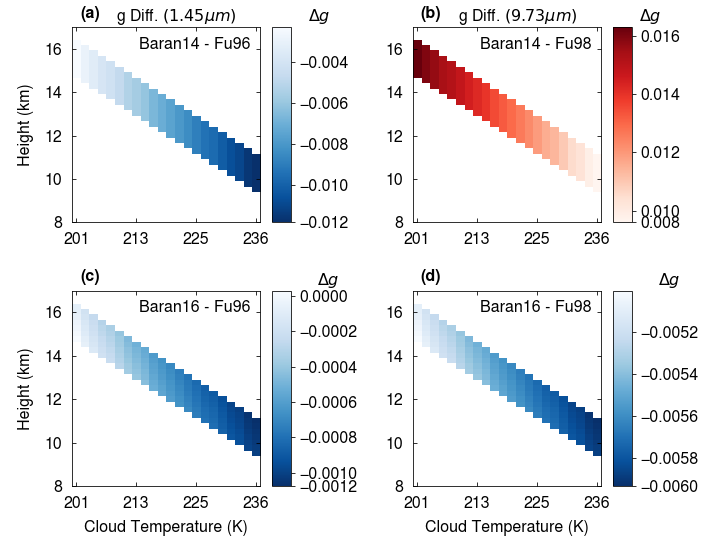

In [88]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 7.5 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if diff == 0:
        # For SW:
        vmini_sw   = -0.001
        vmaxi_sw   = 0.025#-0.004048
        #tickbar_sw = [vmini_sw, -0.75e-5 , 0]
        cmap_sw    = 'Blues_r'#Blues'#'Reds'
        norm_sw = colors.PowerNorm(gamma = 1)#MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        #labelpad    = -30
        #For LW:
        vmini_lw   = -0.0084
        vmaxi_lw   = 0.0001
        #tickbar_lw = [vmini_lw, -0.0175 , 0]
        cmap_lw    = 'Reds'#'RdBu_r'##'Blues'cv
        norm_lw = colors.PowerNorm(gamma = 1)
        schi = diff
    if diff == 1:
        # For SW:
        vmini_sw   = -0.035
        vmaxi_sw   = 0.001
        #tickbar_sw = [vmini_sw, -4.2e-7, 0]
        #labelpad = -30
        cmap_sw    = 'Blues_r'#'Blues'#'Reds'
        norm_sw       = colors.PowerNorm(gamma = 1)#MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        #For LW:
        vmini_lw   = -0.0126
        vmaxi_lw   = 0.044
        #tickbar_lw = [vmini_lw, -3.5e-3 , 0]
        cmap_lw    = 'Blues_r'#'Blues'#'Reds'
        norm_lw = colors.PowerNorm(gamma = 1)
        schi = diff + 1
    
    # Shortwave ssa Difference
    im = ax[diff, 0].imshow(g_sw_t1_diff_plot[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta g$', labelpad = -30, y = 1.1, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title(r'g Diff. $(1.45 \mu m)$', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave ssa Difference
    im = ax[diff, 1].imshow(g_lw_t1_diff_plot[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta g$', labelpad = -30, y = 1.1, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title(r'g Diff. $(9.73 \mu m)$', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, ssa_sw_t1.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_diff_1S_v6c.png', dpi=500)